<a href="https://colab.research.google.com/github/praneethalla/2203A52069/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating synthetic Instagram profile data...
Data Head:
   has_profile_pic  bio_length  has_external_url  is_private  post_count  \
0                0           6                 1           0          12   
1                1          30                 1           0          14   
2                1          98                 1           0         247   
3                1          24                 1           0          18   
4                1          75                 0           0         102   

   follower_count  following_count  is_fake  
0              71             4299        1  
1              23              883        1  
2            1781              423        0  
3              68             1991        1  
4             601              886        0  

Performing feature engineering...
Data with new features:
   has_profile_pic  bio_length  has_external_url  is_private  post_count  \
0                0           6                 1           0          12  

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ANN training complete.
ANN Test Accuracy: 0.9975
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
ANN Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      0.99      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


--- Evaluation & Saving ---


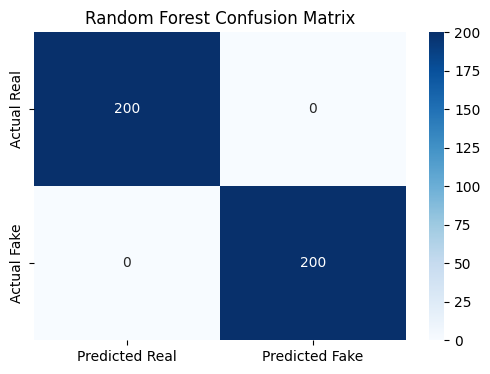

Best model (RandomForest) saved to 'instagram_model.joblib'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

def generate_synthetic_data(n_samples=2000):
    data = []

    # Generate 1000 "Real" profiles
    for _ in range(n_samples // 2):
        data.append({
            'has_profile_pic': 1,
            'bio_length': np.random.randint(20, 150),
            'has_external_url': np.random.choice([0, 1], p=[0.6, 0.4]),
            'is_private': np.random.choice([0, 1], p=[0.7, 0.3]),
            'post_count': np.random.randint(10, 500),
            'follower_count': np.random.randint(50, 2000),
            'following_count': np.random.randint(50, 1000),
            'is_fake': 0
        })

    # Generate 1000 "Fake" (bot/spam) profiles
    for _ in range(n_samples // 2):
        data.append({
            'has_profile_pic': np.random.choice([0, 1], p=[0.4, 0.6]),
            'bio_length': np.random.randint(0, 40),
            'has_external_url': np.random.choice([0, 1], p=[0.1, 0.9]), # Fakes often have spam links
            'is_private': np.random.choice([0, 1], p=[0.9, 0.1]),
            'post_count': np.random.randint(0, 20),
            'follower_count': np.random.randint(0, 100),
            'following_count': np.random.randint(100, 5000), # High following count
            'is_fake': 1
        })

    return pd.DataFrame(data).sample(frac=1).reset_index(drop=True)

print("Generating synthetic Instagram profile data...")
df = generate_synthetic_data(n_samples=2000)

print("Data Head:")
print(df.head())

# ==============================================================================
# 2. FEATURE ENGINEERING
# ==============================================================================
# Create more advanced features from the basic ones
print("\nPerforming feature engineering...")

# Ratio of followers to following. Fakes often have a very low ratio.
# We add 1 to the denominator to avoid division by zero.
df['follower_following_ratio'] = df['follower_count'] / (df['following_count'] + 1)

# Interaction of bio and URL (often spammy)
df['bio_and_url'] = df['bio_length'] * df['has_external_url']

print("Data with new features:")
print(df.head())

# ==============================================================================
# 3. PREPARE DATA FOR MACHINE LEARNING
# ==============================================================================

# Define features (X) and target (y)
features = [
    'has_profile_pic', 'bio_length', 'has_external_url', 'is_private',
    'post_count', 'follower_count', 'following_count',
    'follower_following_ratio', 'bio_and_url'
]

X = df[features]
y = df['is_fake']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data (very important for ANNs and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler so we can use it for real-time prediction
joblib.dump(scaler, 'instagram_scaler.joblib')
print("\nData scaled and scaler saved to 'instagram_scaler.joblib'")

# ==============================================================================
# 4. MODEL COMPARISON
# ==============================================================================

# --- Model 1: Logistic Regression (Baseline) ---
print("\n--- Training Model 1: Logistic Regression ---")
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

# --- Model 2: Random Forest (Advanced ML) ---
# (Often performs best on tabular data like this)
print("\n--- Training Model 2: Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# Note: Random Forest doesn't strictly require scaled data, but it doesn't hurt.
rf_model.fit(X_train, y_train) # Using unscaled data for RF
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

# --- Model 3: Keras ANN (Advanced DL) ---
print("\n--- Training Model 3: Keras ANN ---")
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = ann_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0 # Set to 1 to see training progress
)

print("ANN training complete.")
loss, acc = ann_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"ANN Test Accuracy: {acc:.4f}")

y_pred_ann = (ann_model.predict(X_test_scaled) > 0.5).astype("int32")
print("ANN Report:")
print(classification_report(y_test, y_pred_ann))

# ==============================================================================
# 5. EVALUATE AND SAVE BEST MODEL
# ==============================================================================
print("\n--- Evaluation & Saving ---")

# Based on the reports, Random Forest is likely the most robust and accurate.
# Let's plot its confusion matrix.
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.title('Random Forest Confusion Matrix')
plt.show()

# Save the Random Forest model for our real-time demo
joblib.dump(rf_model, 'instagram_model.joblib')
print("Best model (RandomForest) saved to 'instagram_model.joblib'")

In [ ]:
import joblib
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# ==============================================================================
# 1. LOAD PRE-TRAINED MODEL AND SCALER
# ==============================================================================
# These files must be present (created by the first notebook)
try:
    model = joblib.load('instagram_model.joblib')
    scaler = joblib.load('instagram_scaler.joblib')
    print("✅ Model and Scaler loaded successfully!")
    print("Model type:", type(model))
except FileNotFoundError:
    print("❌ Error: 'instagram_model.joblib' or 'instagram_scaler.joblib' not found.")
    print("Please run the 'Advanced_Instagram_Detector.ipynb' notebook first!")
    # We'll create dummy objects so the rest of the demo can run
    model = None
    scaler = None

# ==============================================================================
# 2. SIMULATED REAL-TIME DATA FETCHING
# ==============================================================================

# !!! THIS IS THE CRITICAL PART !!!
# Actually scraping Instagram is against their Terms of Service and is blocked.
# This function SIMULATES an API call. In a real application, you would
# need a robust, policy-compliant data pipeline here.

def simulate_instagram_api_call(username):
    """
    Simulates fetching data for a username.
    Returns a dictionary of mock data.
    """
    print(f"Simulating API call for: @{username}...")

    if "bot" in username or "spam" in username:
        # Simulate a FAKE profile's stats
        return {
            'has_profile_pic': 1,
            'bio_length': 10,
            'has_external_url': 1,
            'is_private': 0,
            'post_count': 3,
            'follower_count': 50,
            'following_count': 4500
        }
    else:
        # Simulate a REAL profile's stats
        return {
            'has_profile_pic': 1,
            'bio_length': 120,
            'has_external_url': 0,
            'is_private': 1,
            'post_count': 150,
            'follower_count': 800,
            'following_count': 750
        }

# ==============================================================================
# 3. PREDICTION PIPELINE
# ==============================================================================

def predict_profile(username):
    """
    Takes a username, simulates fetching data, processes it,
    and returns a prediction.
    """
    if not model or not scaler:
        return "Error: Model not loaded. Run Part 1 notebook."

    # 1. Get raw data (simulated)
    raw_data = simulate_instagram_api_call(username)

    # 2. Convert to DataFrame
    df = pd.DataFrame([raw_data])

    # 3. Apply the *exact same* feature engineering as in training
    df['follower_following_ratio'] = df['follower_count'] / (df['following_count'] + 1)
    df['bio_and_url'] = df['bio_length'] * df['has_external_url']

    # 4. Ensure columns are in the correct order
    features_list = [
        'has_profile_pic', 'bio_length', 'has_external_url', 'is_private',
        'post_count', 'follower_count', 'following_count',
        'follower_following_ratio', 'bio_and_url'
    ]
    df_processed = df[features_list]

    # 5. Predict
    # NOTE: Our best model (RandomForest) was trained on UNSCALED data.
    # If we were using the ANN, we would need to scale the data first:
    # df_scaled = scaler.transform(df_processed)
    # prediction = model.predict(df_scaled)[0]

    prediction = model.predict(df_processed)[0]
    probability = model.predict_proba(df_processed)[0]

    # 6. Format output
    if prediction == 1:
        return f"🚨 Prediction: FAKE Account (Confidence: {probability[1]:.2%})"
    else:
        return f"✅ Prediction: REAL Account (Confidence: {probability[0]:.2%})"

# ==============================================================================
# 4. CREATE SIMPLE COLAB UI
# ==============================================================================

# Text input widget
username_input = widgets.Text(
    value='john_doe',
    placeholder='Enter Instagram username',
    description='Username:',
    disabled=False
)

# Button widget
predict_button = widgets.Button(
    description='Predict Profile',
    button_style='success',
    tooltip='Click to predict',
    icon='search'
)

# Output widget
prediction_output = widgets.Output()

# Function to call when button is clicked
def on_button_clicked(b):
    with prediction_output:
        clear_output(wait=True)
        username = username_input.value
        if not username:
            print("Please enter a username.")
            return

        result = predict_profile(username)
        print(result)

# Link button to function
predict_button.on_click(on_button_clicked)

# Display the widgets
print("--- Real-Time Prediction Demo ---")
print("Try typing 'john_doe' (simulates REAL) or 'spam_bot_123' (simulates FAKE)\n")
display(username_input, predict_button, prediction_output)

✅ Model and Scaler loaded successfully!
Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
--- Real-Time Prediction Demo ---
Try typing 'john_doe' (simulates REAL) or 'spam_bot_123' (simulates FAKE)



Text(value='john_doe', description='Username:', placeholder='Enter Instagram username')

Button(button_style='success', description='Predict Profile', icon='search', style=ButtonStyle(), tooltip='Cli…

Output()